In [2]:
import pybaseball as pb
import pandas as pd
import matplotlib.pyplot as plt
import tabulate
import seaborn as sns
import pybaseball as pb
pd.set_option("display.max_columns", 100)

In [3]:
# some utility functions

def pprint_df(df, drop_index=True):
    return tabulate.tabulate(df.reset_index(drop=drop_index).fillna(0).values, df.columns, tablefmt="pipe")

def plot_xy(df, title="Pitches"):
    # init plot
    fig,ax = plt.subplots(figsize =(12,12))
        
    # plot the pitches
    for pit_type in df.pitch_name.unique():
        df_pit = df.query(f"pitch_name == '{pit_type}'")
        plt.scatter(df_pit.release_pos_x, df_pit.release_pos_z, marker="o", alpha=.9, color=color_pitch_map[pit_type],  label=pit_type)


In [5]:
# get the data
# this will take a long time, I suggest saving the statcast data to a file
# drake_2019 = pb.statcast('2019-03-01','2019-10-01').query('player_name == "Oliver Drake"')

In [6]:
drake_2019 = pd.read_pickle("../2019_statcast/statcast2019.pkl").query('player_name == "Oliver Drake"')

In [7]:
drake_2019.shape

(941, 90)

In [8]:
# some high level stats to get an idea of pitches
home_away_pitch_splits = drake_2019.groupby(["inning_topbot", "pitch_name"]).size().unstack()
home_away_pitch_splits

pitch_name,4-Seam Fastball,Cutter,Split Finger
inning_topbot,,,
Bot,182.0,1.0,282.0
Top,197.0,NaN,277.0


In [9]:
# that cutter is most likely a misclasification from statcast, so let's just drop it
drake_2019 = drake_2019.query("pitch_name != 'Cutter'")

home_away_pitch_splits = drake_2019.groupby(["inning_topbot", "pitch_name"]).size().unstack()
home_away_pitch_splits

pitch_name,4-Seam Fastball,Split Finger
inning_topbot,,
Bot,182,282
Top,197,277


In [10]:
# for the blog
print(pprint_df(home_away_pitch_splits, drop_index=False))

|     |   4-Seam Fastball |   Split Finger |
|:----|------------------:|---------------:|
| Bot |               182 |            282 |
| Top |               197 |            277 |


In [11]:
# let's see how the position groups if we use 10 bins
drake_2019.groupby([pd.cut(drake_2019.release_pos_x, 10),"pitch_name"]).size().unstack()

pitch_name,4-Seam Fastball,Split Finger
release_pos_x,,
"(-0.119, 0.113]",7.0,2.0
"(0.113, 0.343]",19.0,7.0
"(0.343, 0.573]",4.0,18.0
"(0.573, 0.802]",11.0,7.0
"(0.802, 1.032]",8.0,12.0
"(1.032, 1.262]",56.0,27.0
"(1.262, 1.492]",158.0,121.0
"(1.492, 1.721]",100.0,235.0
"(1.721, 1.951]",16.0,107.0


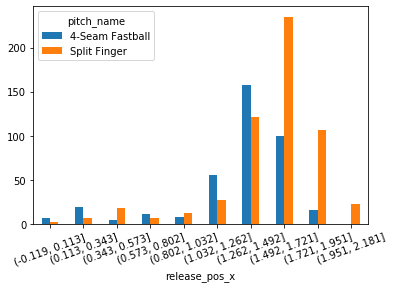

In [12]:
# and plot
drake_2019.groupby([pd.cut(drake_2019.release_pos_x, 10),"pitch_name"]).size().unstack().plot(kind="bar", rot=20)

In [13]:
# let's use cleaner bins

bins = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5]

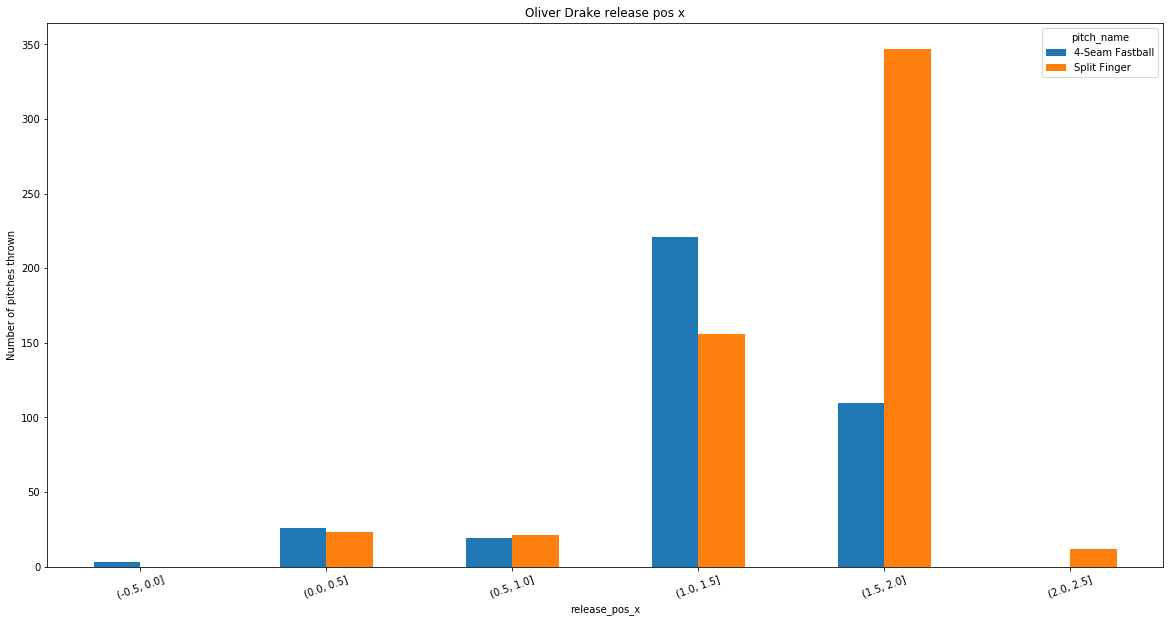

In [14]:
#plot and save
drake_2019.groupby([pd.cut(drake_2019.release_pos_x, bins),"pitch_name"]).size().unstack().plot(kind="bar", rot=20, figsize=(20,10), title="Oliver Drake release pos x")
plt.ylabel("Number of pitches thrown")
plt.savefig("oliver_drake_release_pos_x.jpg")

In [15]:
# plot the release position x and y for each pitch to see the difference

In [16]:
# define a function to plot boxplots to see outliers
def plt_box(df, title="boxplot"):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.boxplot(data=df, x="release_pos_x", y="pitch_name")
    plt.title(title)
    plt.xlim((-1,2.5))
    plt.savefig(title + ".jpg")
    plt.show()

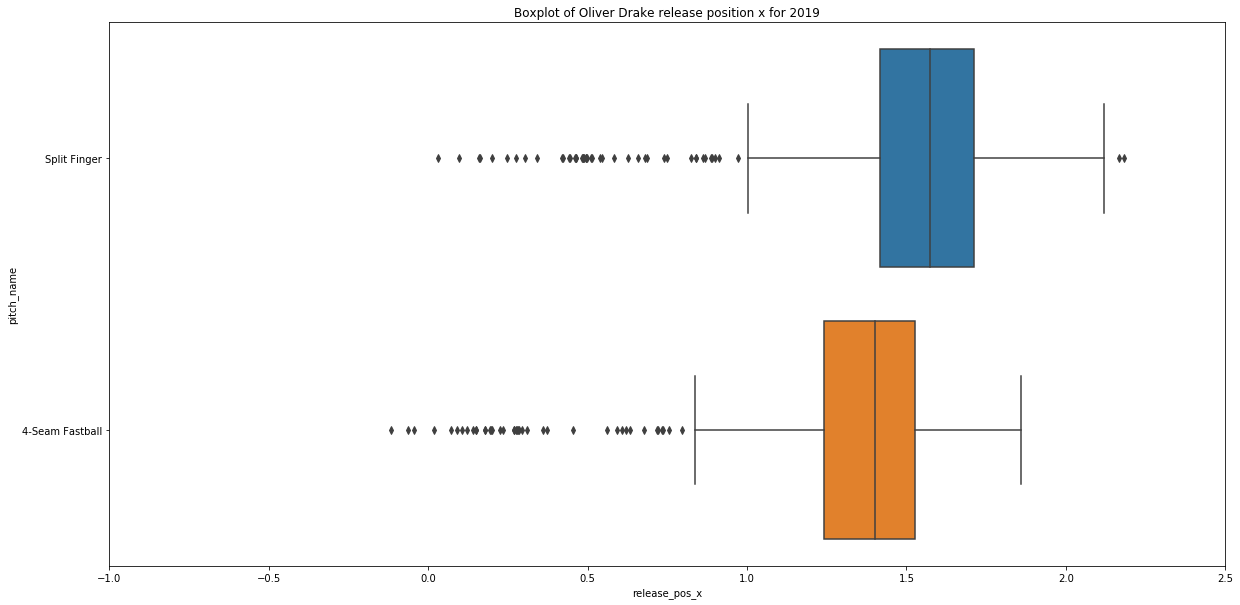

In [17]:
# plot of 2019
plt_box(drake_2019, "Boxplot of Oliver Drake release position x for 2019")

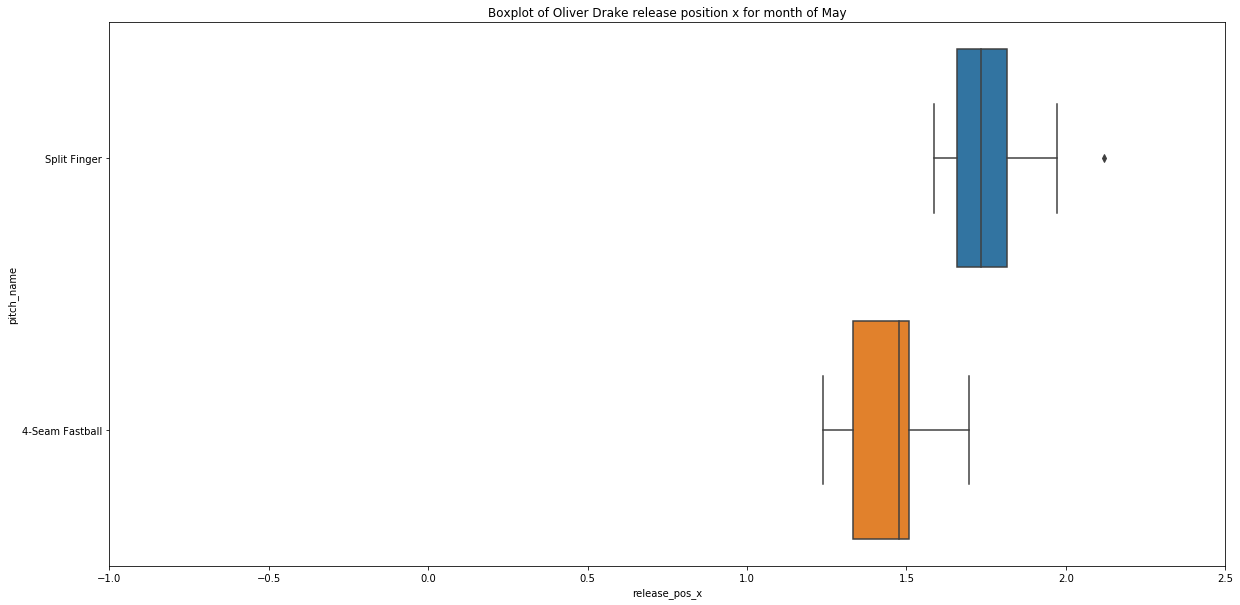

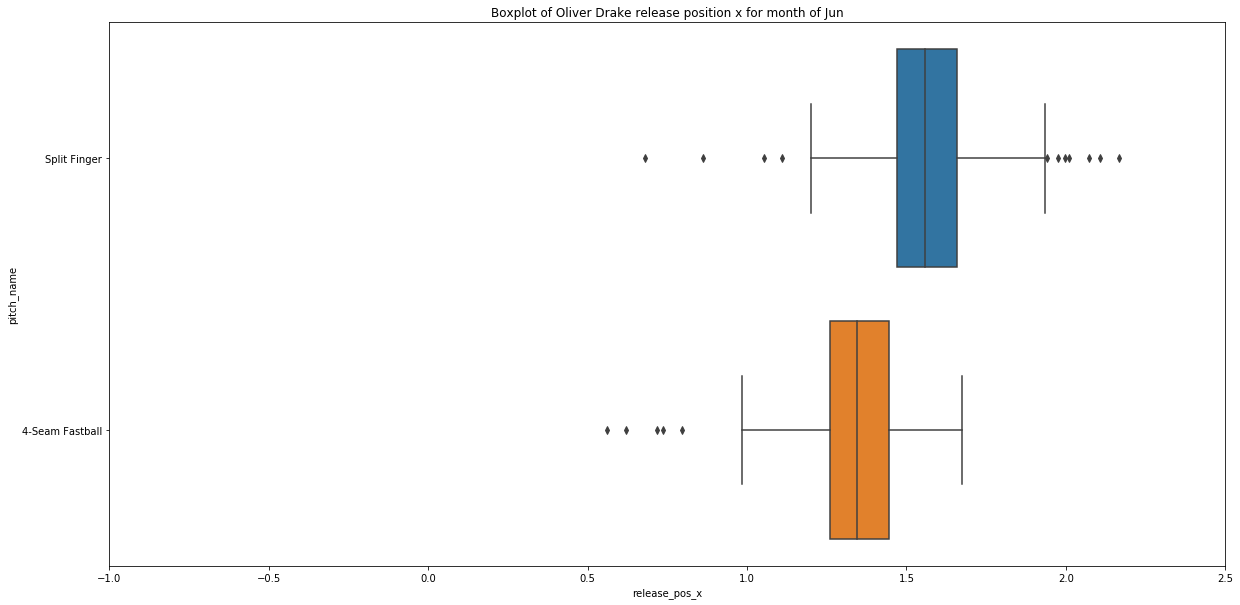

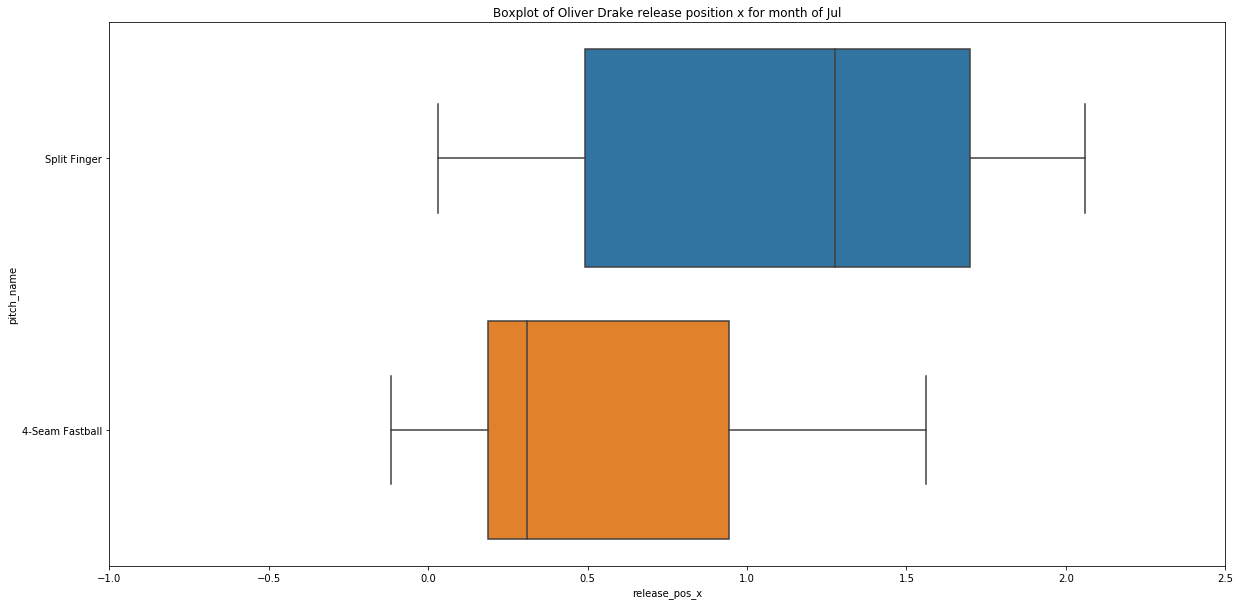

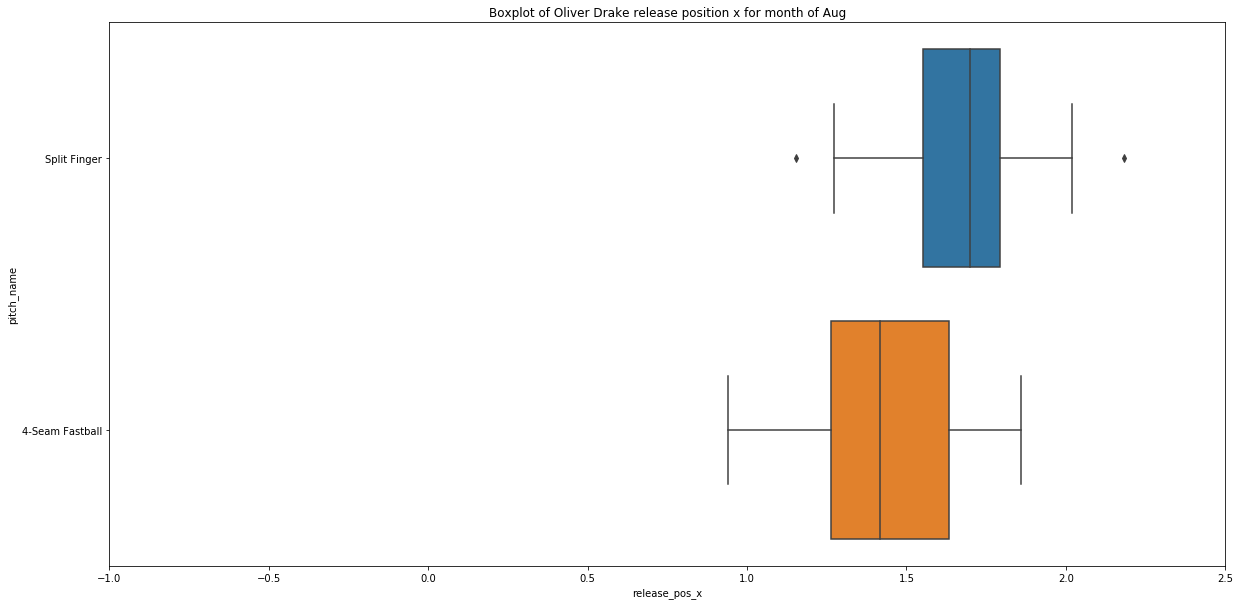

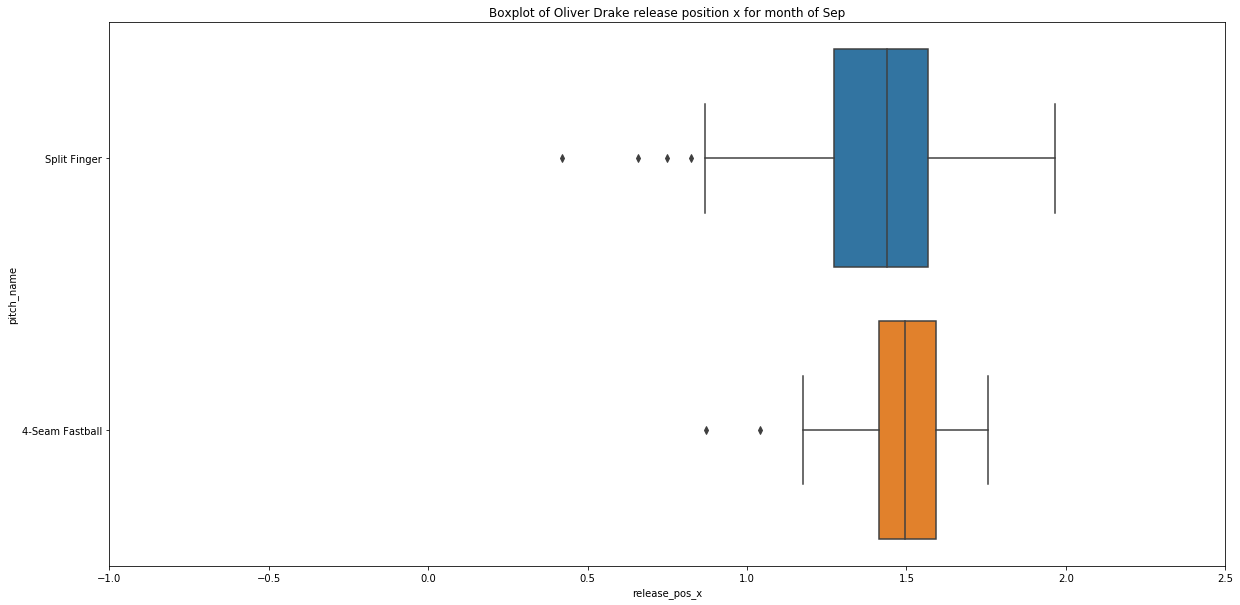

In [18]:
# plot one boxplot for each month

from calendar import month_abbr
for month in range(5,10):
    df = drake_2019[drake_2019.game_date.dt.month == month]
    plt_box(df, f"Boxplot of Oliver Drake release position x for month of {month_abbr[month]}")

In [19]:
# get the names of the batters faced
drake_batters = drake_2019.merge(pb.playerid_reverse_lookup(drake_2019.batter.astype(int)), left_on='batter', right_on='key_mlbam')

Gathering player lookup table. This may take a moment.


In [20]:
# batters in the outlier month
drake_july_batters = drake_batters[drake_batters.game_date.dt.month == 7].groupby(["name_last", "name_first", "stand"]).release_pos_x.mean().reset_index().sort_values("release_pos_x")

In [21]:
# for blog
print(pprint_df(drake_july_batters))

| name_last   | name_first   | stand   |   release_pos_x |
|:------------|:-------------|:--------|----------------:|
| mancini     | trey         | R       |        0.06108  |
| urshela     | gio          | R       |        0.2055   |
| lemahieu    | dj           | R       |        0.252917 |
| voit        | luke         | R       |        0.35665  |
| torres      | gleyber      | R       |        0.371157 |
| judge       | aaron        | R       |        0.4184   |
| guerrero    | vladimir     | R       |        0.53966  |
| engel       | adam         | R       |        0.71694  |
| rondon      | jose         | R       |        0.732925 |
| grichuk     | randal       | R       |        0.91956  |
| villar      | jonathan     | L       |        1.1683   |
| gurriel     | lourdes      | R       |        1.1932   |
| mckinney    | billy        | L       |        1.38177  |
| smith       | dwight       | L       |        1.38665  |
| santander   | anthony      | L       |        1.46014 

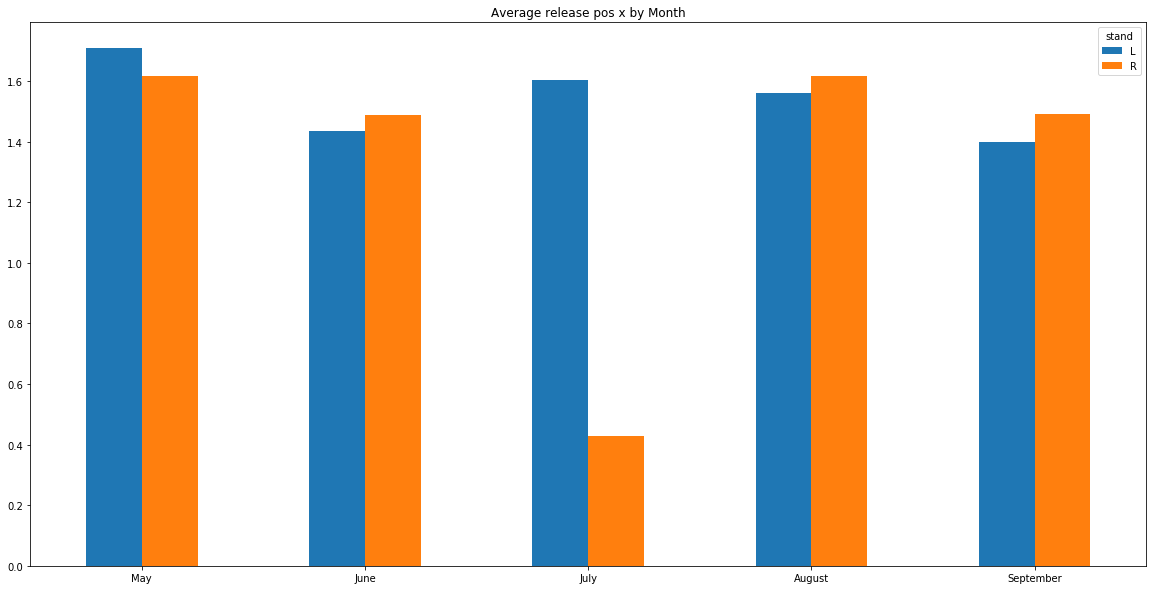

In [22]:
# plot the average position split by batter stance
avg_pos = drake_batters.set_index("game_date").groupby([pd.Grouper(freq='M'), "stand"]).release_pos_x.mean().unstack()
avg_pos.index = avg_pos.index.strftime("%B")
avg_pos.plot(kind="bar", title="Average release pos x by Month", figsize=(20,10), rot=0)
plt.savefig("Average release pos x by Month L vs R.jpg")